In [14]:
import pandas as pd

# Load the data from the uploaded CSV file
file_path = 'HITRUST+Hair_Sales+by++ProductService+Detail (4).csv'
new_sales_data = pd.read_csv(file_path)


In [19]:
# Data cleaning process: Checking and fixing the format of dates and numeric columns

# Convert 'Date' column to datetime format
new_sales_data['Date'] = pd.to_datetime(new_sales_data['Date'], errors='coerce')

# Attempt to convert 'Sales Price' and 'Amount' columns to numeric format, coercing errors to NaN
new_sales_data['Sales Price'] = pd.to_numeric(new_sales_data['Sales Price'].str.replace(' ', '').replace('', 'NaN'), errors='coerce')
new_sales_data['Amount'] = pd.to_numeric(new_sales_data['Amount'].str.replace(' ', '').replace('', 'NaN'), errors='coerce')

# Display data types and check for missing values in key columns
data_types = new_sales_data.dtypes
missing_values = new_sales_data.isnull().sum()

data_types, missing_values


(Date                datetime64[ns]
 Num                         object
 Customer                    object
 Product/Service             object
 Memo/Description            object
 Sales Price                float64
 Qty                        float64
 Amount                     float64
 Customer Type               object
 dtype: object,
 Date                   0
 Num                    1
 Customer               0
 Product/Service        0
 Memo/Description       0
 Sales Price         8143
 Qty                    0
 Amount                45
 Customer Type          0
 dtype: int64)

In [20]:
# Identify customers with any 'Shipping' in their transactions
nonlocal_customers = new_sales_data[new_sales_data['Memo/Description'].str.contains('Shipping', na=False)]['Customer'].unique()

# Label all transactions of these customers as 'nonlocal'
new_sales_data['Customer Type'] = new_sales_data['Customer'].apply(lambda x: 'nonlocal' if x in nonlocal_customers else 'local')

# Verify the labeling by displaying some entries of a customer marked as 'nonlocal'
verification = new_sales_data[new_sales_data['Customer'] == nonlocal_customers[0]][['Customer', 'Memo/Description', 'Customer Type']].head()
verification


,Customer,Memo/Description,Customer Type
1,Joannis Correa_3058,Shipping,nonlocal
74,Joannis Correa_3058,9A BW 24”,nonlocal
75,Joannis Correa_3058,"8A BW 18""",nonlocal
189,Joannis Correa_3058,No Description,nonlocal
190,Joannis Correa_3058,Shipping,nonlocal


In [21]:
# Fill missing values in 'Product/Service' with 'Unknown Product/Service'
new_sales_data['Product/Service'].fillna('Unknown Product/Service', inplace=True)

# Fill missing values in 'Sales Price' and 'Qty' with zeros
new_sales_data['Sales Price'].fillna(0, inplace=True)
new_sales_data['Qty'].fillna(0, inplace=True)

# Fill missing values in 'Memo/Description' with 'No Description'
new_sales_data['Memo/Description'].fillna('No Description', inplace=True)

# Remove rows where 'Amount' is missing
new_sales_data.dropna(subset=['Amount'], inplace=True)

# Confirm changes by showing the updated missing value count and a sample of the data
updated_missing_values = new_sales_data.isnull().sum()
updated_sample = new_sales_data.head()

updated_missing_values, updated_sample


(Date                0
 Num                 1
 Customer            0
 Product/Service     0
 Memo/Description    0
 Sales Price         0
 Qty                 0
 Amount              0
 Customer Type       0
 dtype: int64,
         Date                Num              Customer  \
 0 2021-01-18  00210991643210737                Tyaira   
 1 2021-01-18  00210991643210741   Joannis Correa_3058   
 2 2021-01-18  00210991643210731  Jacquetta Scott_3891   
 3 2021-01-18  00210991643210731  Jacquetta Scott_3891   
 4 2021-01-18  00210991643210731  Jacquetta Scott_3891   
 
            Product/Service Memo/Description  Sales Price  Qty  Amount  \
 0             HD 5*5 lw 18   No Description         91.5  1.0    91.5   
 1  Unknown Product/Service         Shipping          0.0  0.0    20.0   
 2                 VA BW 12        8A  BW12"         18.5  1.0    18.5   
 3                 VA BW 16        8A BW 16”         24.5  1.0    24.5   
 4                 VA BW 20        8A Bw 20”         31.5 

In [22]:
# Rechecking the data types of key columns to ensure correct formatting
data_types_recheck = new_sales_data.dtypes

# Display data types to confirm everything is as expected
data_types_recheck


Date                datetime64[ns]
Num                         object
Customer                    object
Product/Service             object
Memo/Description            object
Sales Price                float64
Qty                        float64
Amount                     float64
Customer Type               object
dtype: object

In [23]:
import pandas as pd

# Assuming 'Date' is already in datetime format and sorted, if not we need to sort it
new_sales_data.sort_values('Date', inplace=True)

# Find the most recent transaction date in the data
latest_date = new_sales_data['Date'].max()

# Define the cutoff date for churn (6 months before the latest transaction date)
cutoff_date = latest_date - pd.DateOffset(months=6)

# Group by customer and find the date of the last purchase
customer_last_purchase = new_sales_data.groupby('Customer')['Date'].max().reset_index()

# Identify churned customers who have not purchased since the cutoff date
customer_last_purchase['Churned'] = customer_last_purchase['Date'].apply(lambda x: 'Yes' if x <= cutoff_date else 'No')

# Display the first few rows of the churned customers data
churned_customers = customer_last_purchase.head()

churned_customers


,Customer,Date,Churned
0,+1 (203) 706-9550,2023-04-17,Yes
1,+1 (215) 301-9994,2023-04-18,Yes
2,+1 (302) 784-5540,2023-03-22,Yes
3,+1 (314) 320-4208,2023-03-03,Yes
4,+1 (404) 966-7980,2023-04-18,Yes


In [24]:
# Calculate overall churn rate
total_customers = customer_last_purchase.shape[0]
churned_customers_count = customer_last_purchase[customer_last_purchase['Churned'] == 'Yes'].shape[0]
churn_rate = (churned_customers_count / total_customers) * 100

# Calculate churn rate by customer type
churn_by_type = new_sales_data.groupby('Customer Type').apply(
    lambda x: (x.groupby('Customer')['Date'].max() <= cutoff_date).mean() * 100
).reset_index(name='Churn Rate')

churn_rate, churn_by_type


(67.94240242516103,
   Customer Type  Churn Rate
 0         local   70.191835
 1      nonlocal   60.396040)

In [25]:
# Merge the churn data back to the main sales data to analyze behavior
behavior_data = new_sales_data.merge(customer_last_purchase[['Customer', 'Churned']], on='Customer', how='left')

# Calculate purchase frequency and average spending for churned and retained customers
purchase_frequency = behavior_data.groupby(['Customer', 'Churned'])['Date'].count().reset_index().groupby('Churned')['Date'].mean()
average_spending = behavior_data.groupby(['Customer', 'Churned'])['Amount'].sum().reset_index().groupby('Churned')['Amount'].mean()

# Results
purchase_frequency, average_spending


(Churned
 No     40.054374
 Yes    11.536531
 Name: Date, dtype: float64,
 Churned
 No     3789.681052
 Yes    1384.188076
 Name: Amount, dtype: float64)

In [26]:
# Standardize product names by removing 'VIP:' prefix
behavior_data['Standardized Product'] = behavior_data['Product/Service'].str.replace('VIP:', '').str.strip()

# Calculate the frequency of product purchases for churned and retained customers
product_preferences = behavior_data.groupby(['Standardized Product', 'Churned'])['Num'].count().unstack(fill_value=0)
product_preferences['Total'] = product_preferences.sum(axis=1)
product_preferences.sort_values('Total', ascending=False, inplace=True)

# Display the top products to see the difference in purchasing patterns
top_product_preferences = product_preferences.head(10)
top_product_preferences


Churned,No,Yes,Total
Standardized Product,,,
Unknown Product/Service,3908,1608,5516
"VA+ BW 22""",468,138,606
"VA+ BW 20""",498,107,605
"VA+ BW 18""",477,85,562
"VA+ BW 24""",403,139,542
VA+ BW 18”,239,220,459
VA+ BW 22”,256,199,455
hd 5*5 bw 16,328,122,450
VA+ BW 24”,241,203,444


In [28]:
# Extract year and month from the 'Date' for grouping
behavior_data['YearMonth'] = behavior_data['Date'].dt.to_period('M')

# Calculate monthly churn rates
monthly_churn_data = behavior_data.groupby(['YearMonth', 'Customer'])['Churned'].max().reset_index()
monthly_churn_rates = monthly_churn_data.groupby('YearMonth')['Churned'].apply(lambda x: (x == 'Yes').mean() * 100)




In [29]:
# Convert 'Churned' from Yes/No to 1/0 for correlation analysis
behavior_data['Churned_Flag'] = (behavior_data['Churned'] == 'Yes').astype(int)

# Calculate correlations of 'Churned_Flag' with 'Qty' (as a proxy for frequency) and 'Amount' (as a proxy for spending)
correlation_data = behavior_data[['Churned_Flag', 'Qty', 'Amount']]
correlations = correlation_data.corr()

correlations


,Churned_Flag,Qty,Amount
Churned_Flag,1.000000,-0.011151,0.122395
Qty,-0.011151,1.000000,0.093990
Amount,0.122395,0.093990,1.000000


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Prepare data for logistic regression
# Encoding categorical variables
encoder = LabelEncoder()
behavior_data['Customer Type Encoded'] = encoder.fit_transform(behavior_data['Customer Type'])
behavior_data['Product Encoded'] = encoder.fit_transform(behavior_data['Standardized Product'])

# Selecting features for the model
X = behavior_data[['Qty', 'Amount', 'Customer Type Encoded', 'Product Encoded']]
y = behavior_data['Churned_Flag']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions and performance evaluation
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)

report


'              precision    recall  f1-score   support\n\n           0       0.63      0.93      0.75     10147\n           1       0.50      0.10      0.17      6225\n\n    accuracy                           0.62     16372\n   macro avg       0.56      0.52      0.46     16372\nweighted avg       0.58      0.62      0.53     16372\n'

In [32]:
# Calculate the time between purchases for each customer
behavior_data['Previous Purchase Date'] = behavior_data.groupby('Customer')['Date'].shift(1)
behavior_data['Days Between Purchases'] = (behavior_data['Date'] - behavior_data['Previous Purchase Date']).dt.days

# Average time between purchases per customer
avg_time_between_purchases = behavior_data.groupby('Customer')['Days Between Purchases'].mean()

# Count of unique product types purchased by each customer
product_variety = behavior_data.groupby('Customer')['Standardized Product'].nunique()

# Merge these new features into the main dataset
customer_features = behavior_data[['Customer', 'Churned_Flag']].drop_duplicates().set_index('Customer')
customer_features['Avg Days Between Purchases'] = avg_time_between_purchases
customer_features['Product Variety'] = product_variety

customer_features.reset_index(inplace=True)

# Display a sample of the new features
customer_features.head()


,Customer,Churned_Flag,Avg Days Between Purchases,Product Variety
0,Tyaira,0,3.842105,101
1,Randall Woods,0,6.112994,108
2,Ashley,0,8.680000,84
3,hair_by_jah,1,1.367647,47
4,Jacquetta Scott_3891,0,0.417087,431


In [34]:
# Create a new binary feature indicating whether a discount was applied (VIP)
behavior_data['Discount Applied'] = behavior_data['Product/Service'].apply(lambda x: 1 if 'VIP:' in str(x) else 0)

# Update customer_features with the discount information
discount_info = behavior_data.groupby('Customer')['Discount Applied'].max()
customer_features['Discount Applied'] = customer_features['Customer'].map(discount_info)

# Fill missing values in 'Avg Days Between Purchases' with the median of the available values
median_days_between_purchases = customer_features['Avg Days Between Purchases'].median()
customer_features['Avg Days Between Purchases'].fillna(median_days_between_purchases, inplace=True)

# Update logistic regression model including new features
X = customer_features[['Avg Days Between Purchases', 'Product Variety', 'Discount Applied']]
y = customer_features['Churned_Flag']

# Splitting data into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic regression model
updated_model.fit(X_train, y_train)

# Predictions and performance evaluation
updated_predictions = updated_model.predict(X_test)
updated_report = classification_report(y_test, updated_predictions)

updated_report


'              precision    recall  f1-score   support\n\n           0       0.65      0.13      0.22       251\n           1       0.71      0.97      0.82       541\n\n    accuracy                           0.70       792\n   macro avg       0.68      0.55      0.52       792\nweighted avg       0.69      0.70      0.63       792\n'

In [36]:
from sklearn.ensemble import RandomForestClassifier

# Configure the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions and evaluate the model
rf_predictions = rf_model.predict(X_test)
rf_report = classification_report(y_test, rf_predictions)

rf_report


'              precision    recall  f1-score   support\n\n           0       0.51      0.35      0.41       251\n           1       0.74      0.85      0.79       541\n\n    accuracy                           0.69       792\n   macro avg       0.62      0.60      0.60       792\nweighted avg       0.67      0.69      0.67       792\n'

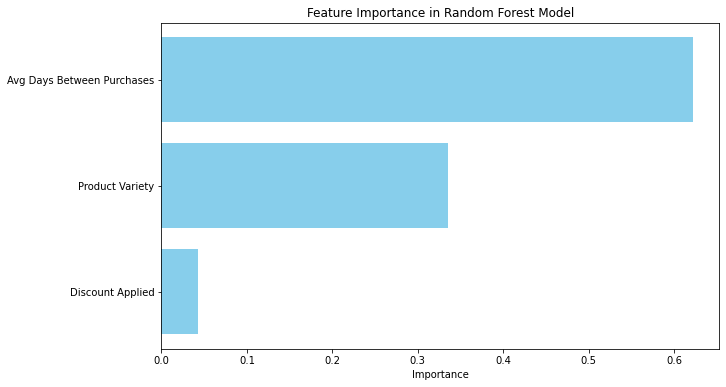

In [37]:
import matplotlib.pyplot as plt

# Extract feature importances from the model
feature_importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame to visualize the feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


In [38]:
from sklearn.model_selection import GridSearchCV

# Setting up parameter grid to tune the model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy',  # can be adjusted to other metrics
                           verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50},
 0.7162938548304402)

In [39]:
# Re-train Random Forest model with the optimal parameters
tuned_rf_model = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=10, random_state=42)
tuned_rf_model.fit(X_train, y_train)

# Make predictions and evaluate the model with the tuned parameters
tuned_rf_predictions = tuned_rf_model.predict(X_test)
tuned_rf_report = classification_report(y_test, tuned_rf_predictions)

tuned_rf_report


'              precision    recall  f1-score   support\n\n           0       0.64      0.34      0.45       251\n           1       0.75      0.91      0.82       541\n\n    accuracy                           0.73       792\n   macro avg       0.70      0.63      0.63       792\nweighted avg       0.72      0.73      0.70       792\n'

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

# Set up the Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gbm_model.fit(X_train, y_train)

# Make predictions and evaluate the model
gbm_predictions = gbm_model.predict(X_test)
gbm_report = classification_report(y_test, gbm_predictions)

gbm_report


'              precision    recall  f1-score   support\n\n           0       0.67      0.27      0.39       251\n           1       0.74      0.94      0.82       541\n\n    accuracy                           0.73       792\n   macro avg       0.70      0.61      0.61       792\nweighted avg       0.71      0.73      0.69       792\n'

In [42]:
from sklearn.neural_network import MLPClassifier

# Define the MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', max_iter=300, random_state=42)

# Train the model
mlp_model.fit(X_train, y_train)

# Predictions and evaluate the model
mlp_predictions = mlp_model.predict(X_test)
mlp_report = classification_report(y_test, mlp_predictions)

mlp_report


'              precision    recall  f1-score   support\n\n           0       0.76      0.20      0.32       251\n           1       0.72      0.97      0.83       541\n\n    accuracy                           0.73       792\n   macro avg       0.74      0.58      0.57       792\nweighted avg       0.73      0.73      0.67       792\n'